In [28]:
from typing import Dict, NamedTuple, List, Union, Optional

import os
import numpy as np
import pandas as pd
import torch
import yaml

from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms
import albumentations as albu
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set()

from PIL import Image
from wheel5.dataset import LMDBImageDataset, TransformDataset, AlbumentationsDataset
from wheel5.transforms import Rescale, PadToSquare, SquarePaddedResize
from wheel5.visualization import visualize_samples, direct_display_image

In [2]:
with open('../config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

In [65]:
def load_image_dataset(config: Dict[str, str], augment: bool=False) -> LMDBImageDataset:
    dataframe = config['dataframe']
    image_dir = config['image_dir']
    lmdb_path = os.path.join(config['lmdb_dir'], 'plays4')
    
    df_images = pd.read_csv(filepath_or_buffer=dataframe, sep=',', header=0)
    
    lmdb_transform = transforms.Compose([
        Rescale(scale=0.5, interpolation=Image.LANCZOS),
        PadToSquare()
    ])
    
    aug_transform = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.ToGray(p=0.1),
        albu.ShiftScaleRotate(shift_limit=0.1,
                              scale_limit=(-0.2, 0.1),
                              rotate_limit=15,
                              border_mode=cv2.BORDER_CONSTANT,
                              value=0,
                              interpolation=cv2.INTER_LANCZOS4,
                              p=1.0)
    ])
    
    model_transform = SquarePaddedResize(size=224, interpolation=Image.LANCZOS)
    
    dataset = LMDBImageDataset.cached(df_images, 
                                      image_dir=image_dir, 
                                      lmdb_path=lmdb_path, 
                                      lmdb_map_size=int(32 * (1024 ** 3)),
                                      transform=lmdb_transform) 
    
    dataset = AlbumentationsDataset(dataset, transform=aug_transform) if augment else dataset        
    dataset = TransformDataset(dataset, transform=model_transform)
    
    return dataset

In [66]:
datasets_config = config['datasets']

train_dataset_aug = load_image_dataset(datasets_config['train'], augment=True)
train_dataset = load_image_dataset(datasets_config['train'])

public_test_dataset = load_image_dataset(datasets_config['public_test'])
private_test_dataset = load_image_dataset(datasets_config['private_test'])

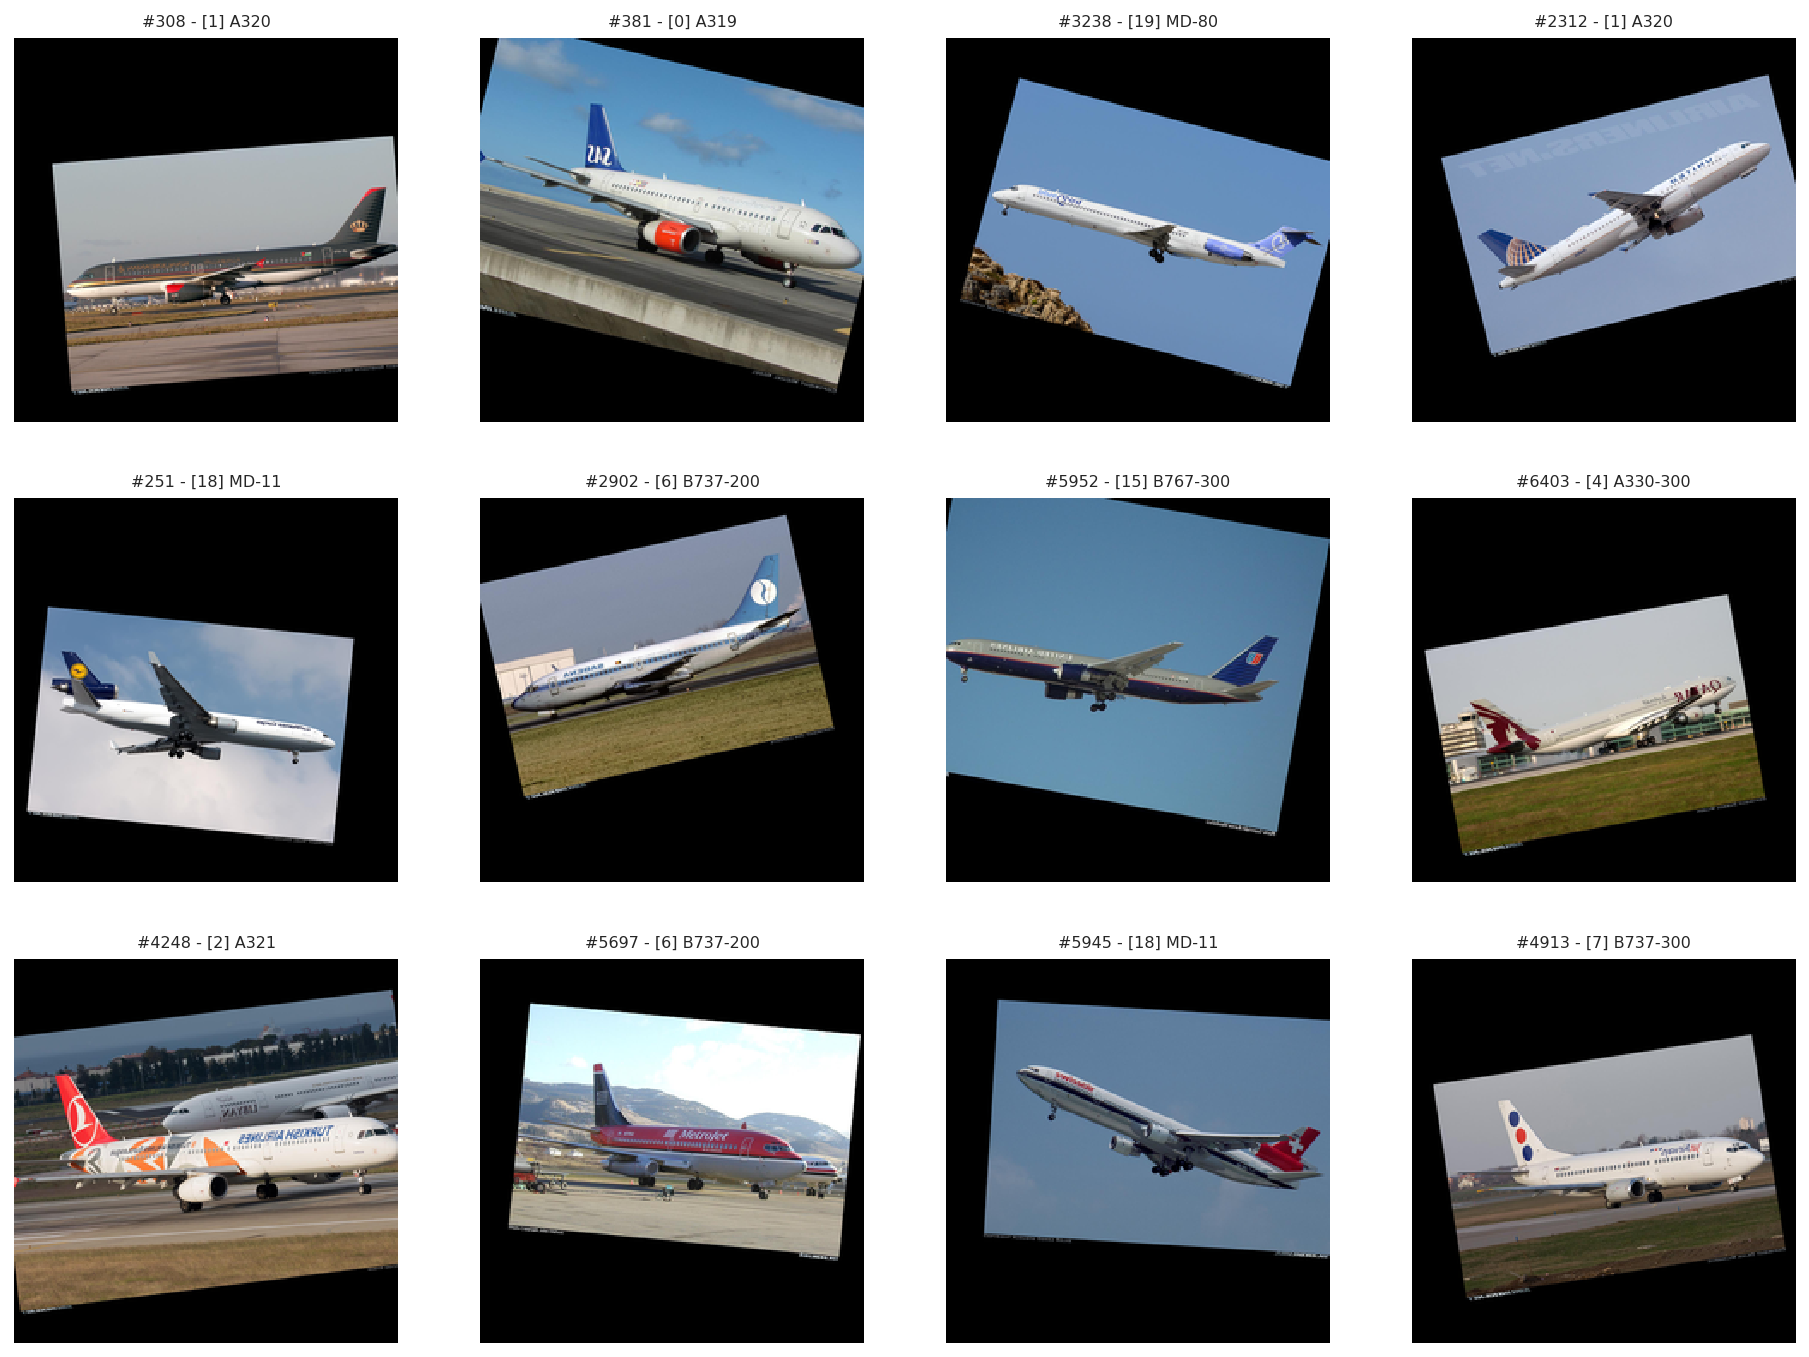

In [67]:
visualize_samples(train_dataset_aug, cols=4, rows=3, width=4, height=4, random_state=np.random.RandomState(42))

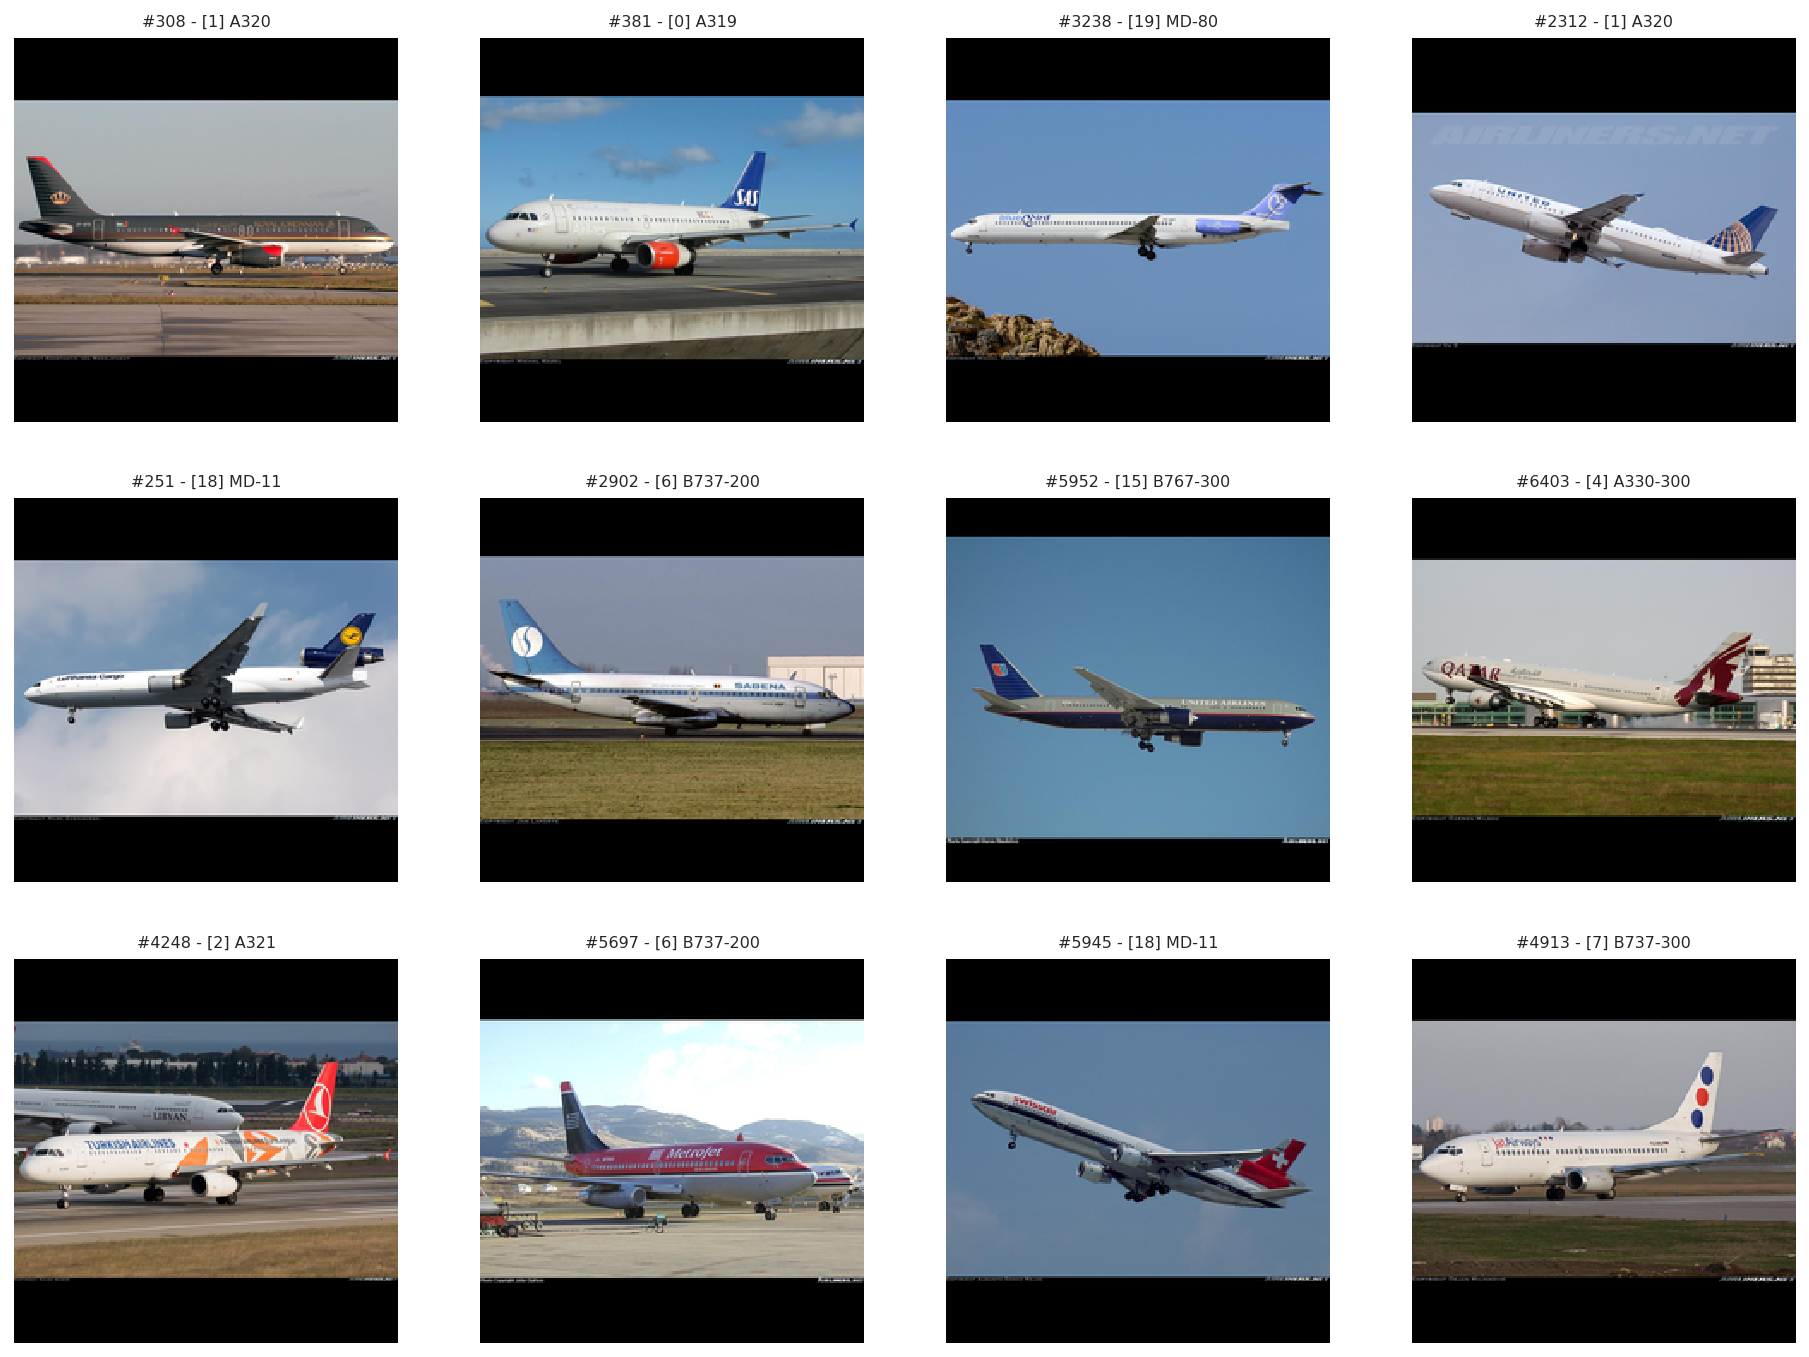

In [49]:
visualize_samples(train_dataset, cols=4, rows=3, width=4, height=4, random_state=np.random.RandomState(42))

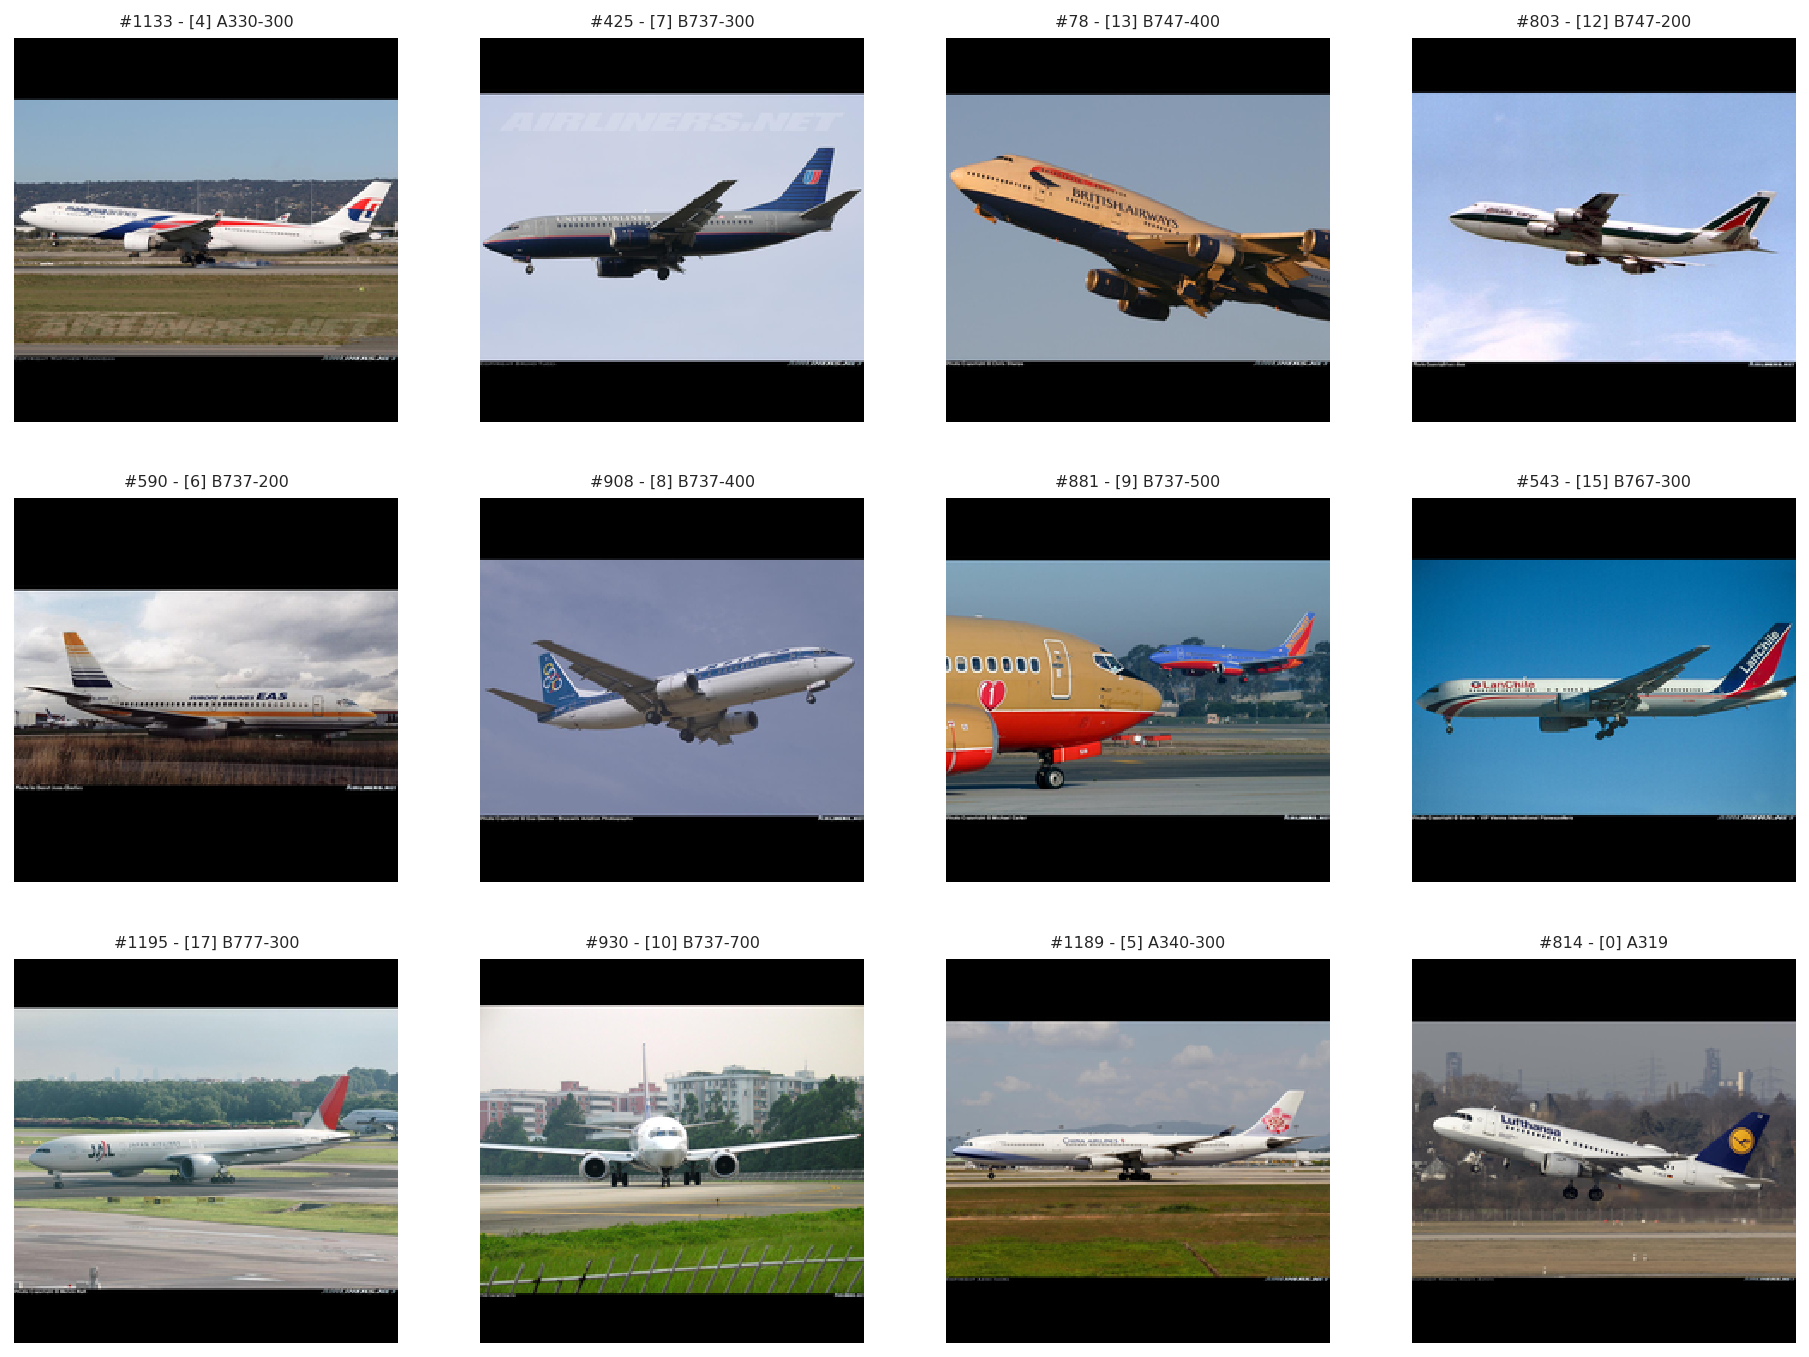

In [44]:
visualize_samples(public_test_dataset, cols=4, rows=3, width=4, height=4, random_state=np.random.RandomState(42))

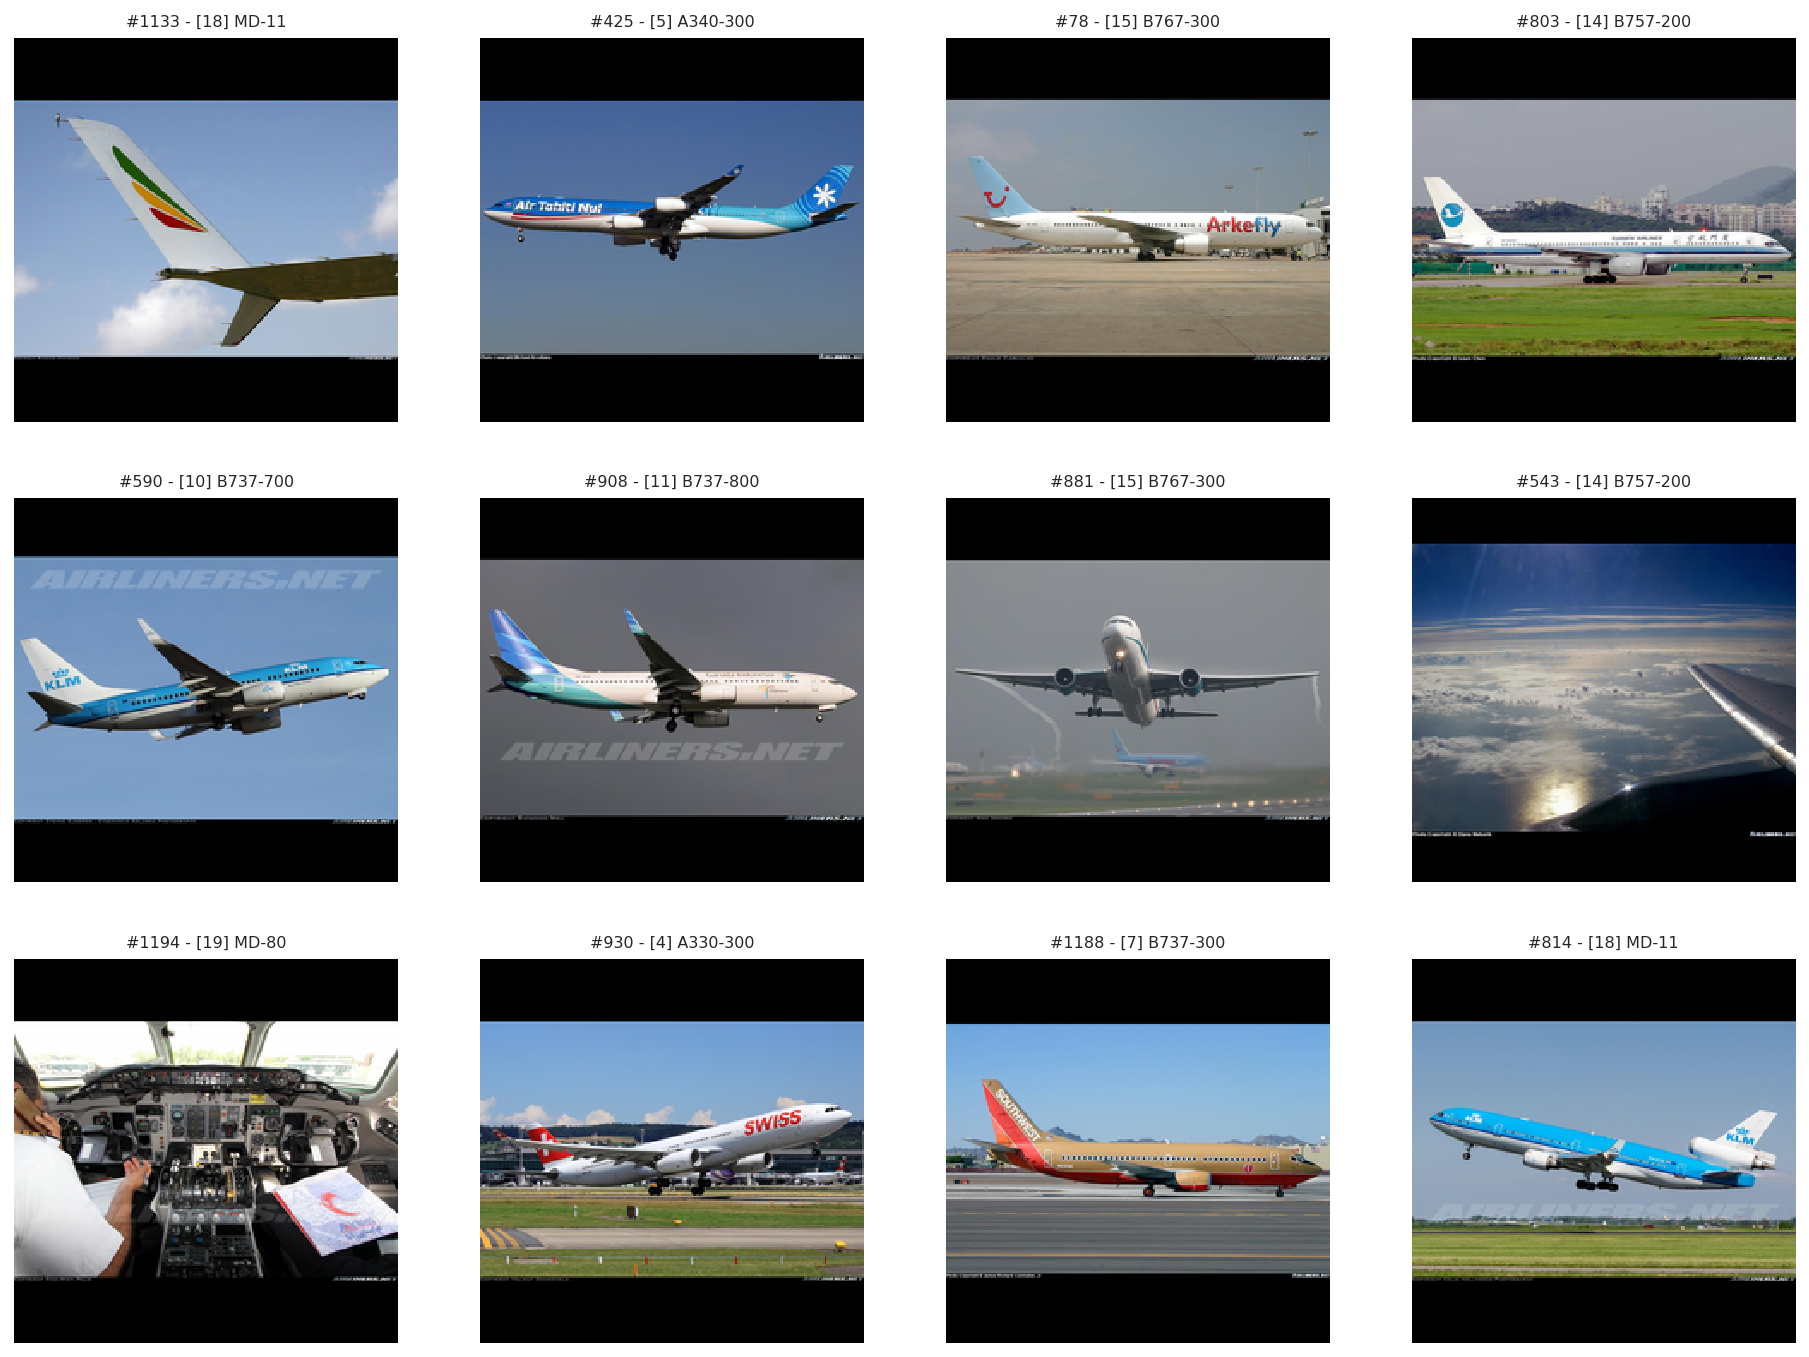

In [45]:
visualize_samples(private_test_dataset, cols=4, rows=3, width=4, height=4, random_state=np.random.RandomState(42))